# Graduate Visitor Scheduler: Getting Started Notebook

This notebook is a self-contained large example intended for first-time users.

It demonstrates a realistic scenario with:
- 10 visitors
- 6 faculty (`Prof. A` to `Prof. F`)
- 2 buildings (`ABC` and `XYZ`)
- 3 research areas (`Energy`, `Bio`, `Theory`)
- faculty availability conflicts

By the end, you will have:
1. written all required input files from the notebook,
2. solved the scheduling MILP,
3. visualized visitor and faculty schedules,
4. exported individualized schedules to DOCX.

## 0) Install Dependencies (Colab-Friendly)

If you run this in Colab, execute this cell first. It is safe to re-run.

In [1]:
import sys

# Check if running in Google Colab
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:

    # Install necessary packages in Colab environment
    %pip install -q grad-visitor-scheduler pandas pyyaml matplotlib seaborn python-docx

## 1) Imports

In [2]:
from pathlib import Path
from textwrap import dedent

import sys
import pandas as pd
from IPython.display import Image, display

IN_COLAB = "google.colab" in sys.modules
if not IN_COLAB:
    def find_repo_root(start: Path) -> Path:
        for parent in [start] + list(start.parents):
            if (parent / "pyproject.toml").exists():
                return parent
        return start

    repo_root = find_repo_root(Path.cwd())
    src_path = repo_root / "src"
    if src_path.exists():
        sys.path.insert(0, str(src_path))

from grad_visit_scheduler import scheduler_from_configs, Mode, Solver, export_visitor_docx


## 2) Define and Write Input Files

The scheduler uses three files:
- **Faculty catalog YAML**: faculty metadata, building, room, areas, status.
- **Run config YAML**: meeting slots, building order, break slots, area/availability settings.
- **Visitor CSV**: ranked faculty preferences (`Prof1`..`Prof4`) and topic preferences (`Area1`, `Area2`).

Edit these blocks directly to experiment with different scenarios.

In [3]:
# Define the faculty information including name, building abbreviation, 
# room number, research areas, and status. Aliases can be used to map different 
# names (e.g., nicknames, common misspellings) to the same faculty member,
# 
# This information is stored in a YAML format for easy parsing.
faculty_yaml = dedent('''
faculty:
  Prof. A:
    building: ABC
    room: "201"
    areas: ["Energy", "Theory"]
    status: active
  Prof. B:
    building: XYZ
    room: "102"
    areas: ["Bio"]
    status: active
  Prof. C:
    building: ABC
    room: "203"
    areas: ["Theory"]
    status: active
  Prof. D:
    building: XYZ
    room: "104"
    areas: ["Energy"]
    status: active
  Prof. E:
    building: ABC
    room: "205"
    areas: ["Bio", "Energy"]
    status: active
  Prof. F:
    building: XYZ
    room: "106"
    areas: ["Theory", "Bio"]
    status: active

aliases: {}
''').strip()

# Define the building names (or abbreviations) and the time slots available 
# for visits in each building
# 
# Specify which time slots are available for breaks.
# 
# Specify the research areas relevant to the visits. The program includes error checking to ensure that 
# these areas align with faculty and visitor data.
#
# Specify the weight given to the first (Area1) and second (Area2) research area 
# preferences given by the visitors.
#
# Specify for each faculty member which time slots they are available for visits.
config_yaml = dedent('''
buildings:
  ABC: ["1:00-1:25", "1:30-1:55", "2:00-2:25", "2:30-2:55"]
  XYZ: ["1:00-1:25", "1:30-1:55", "2:00-2:25", "2:30-2:55"]
building_order: ["ABC", "XYZ"]
breaks: [2, 3]

areas: ["Energy", "Bio", "Theory"]

# Weights are keyed by CSV columns (Area1, Area2), not area names.
area_weights:
  Area1: 1.0
  Area2: 0.5

faculty_availability:
  Prof. A: [1, 2, 3, 4]
  Prof. B: [1, 2, 4]
  Prof. C: [1, 3, 4]
  Prof. D: [2, 3, 4]
  Prof. E: [1, 2, 3]
  Prof. F: [1, 3, 4]
''').strip()

# Define the visitor information, including their name, ranked preferences for faculty meetings (Prof1-Prof4), 
# and their research area preferences (Area1, Area2). This information is stored in a CSV format for easy parsing.
# You may find it easier to create and edit this information in a spreadsheet program and then export it as CSV.
visitor_rows = [
    {"Name": "Visitor 01", "Prof1": "Prof. A", "Prof2": "Prof. C", "Prof3": "Prof. E", "Prof4": "Prof. F", "Area1": "Energy", "Area2": "Theory"},
    {"Name": "Visitor 02", "Prof1": "Prof. B", "Prof2": "Prof. D", "Prof3": "Prof. F", "Prof4": "Prof. C", "Area1": "Bio", "Area2": "Energy"},
    {"Name": "Visitor 03", "Prof1": "Prof. C", "Prof2": "Prof. A", "Prof3": "Prof. E", "Prof4": "Prof. B", "Area1": "Theory", "Area2": "Energy"},
    {"Name": "Visitor 04", "Prof1": "Prof. D", "Prof2": "Prof. F", "Prof3": "Prof. B", "Prof4": "Prof. A", "Area1": "Energy", "Area2": "Bio"},
    {"Name": "Visitor 05", "Prof1": "Prof. E", "Prof2": "Prof. C", "Prof3": "Prof. A", "Prof4": "Prof. D", "Area1": "Bio", "Area2": "Theory"},
    {"Name": "Visitor 06", "Prof1": "Prof. F", "Prof2": "Prof. B", "Prof3": "Prof. D", "Prof4": "Prof. E", "Area1": "Theory", "Area2": "Bio"},
    {"Name": "Visitor 07", "Prof1": "Prof. A", "Prof2": "Prof. E", "Prof3": "Prof. C", "Prof4": "Prof. D", "Area1": "Energy", "Area2": "Bio"},
    {"Name": "Visitor 08", "Prof1": "Prof. B", "Prof2": "Prof. F", "Prof3": "Prof. D", "Prof4": "Prof. A", "Area1": "Bio", "Area2": "Theory"},
    {"Name": "Visitor 09", "Prof1": "Prof. C", "Prof2": "Prof. E", "Prof3": "Prof. A", "Prof4": "Prof. B", "Area1": "Theory", "Area2": "Energy"},
    {"Name": "Visitor 10", "Prof1": "Prof. D", "Prof2": "Prof. B", "Prof3": "Prof. F", "Prof4": "Prof. C", "Area1": "Energy", "Area2": "Theory"},
]

faculty_path = Path("faculty_info_colab.yaml")
config_path = Path("config_info_colab.yaml")
visitors_path = Path("data_visitors_colab.csv")

faculty_path.write_text(faculty_yaml, encoding='utf-8')
config_path.write_text(config_yaml, encoding='utf-8')
pd.DataFrame(visitor_rows).to_csv(visitors_path, index=False)

faculty_path, config_path, visitors_path

(PosixPath('faculty_info_colab.yaml'),
 PosixPath('config_info_colab.yaml'),
 PosixPath('data_visitors_colab.csv'))

### Quick Input Inspection

In [4]:
visitors_df = pd.read_csv(visitors_path)
display(visitors_df)

,Name,Prof1,Prof2,Prof3,Prof4,Area1,Area2
0,Visitor 01,Prof. A,Prof. C,Prof. E,Prof. F,Energy,Theory
1,Visitor 02,Prof. B,Prof. D,Prof. F,Prof. C,Bio,Energy
2,Visitor 03,Prof. C,Prof. A,Prof. E,Prof. B,Theory,Energy
3,Visitor 04,Prof. D,Prof. F,Prof. B,Prof. A,Energy,Bio
4,Visitor 05,Prof. E,Prof. C,Prof. A,Prof. D,Bio,Theory
5,Visitor 06,Prof. F,Prof. B,Prof. D,Prof. E,Theory,Bio
6,Visitor 07,Prof. A,Prof. E,Prof. C,Prof. D,Energy,Bio
7,Visitor 08,Prof. B,Prof. F,Prof. D,Prof. A,Bio,Theory
8,Visitor 09,Prof. C,Prof. E,Prof. A,Prof. B,Theory,Energy
9,Visitor 10,Prof. D,Prof. B,Prof. F,Prof. C,Energy,Theory


## 3) Build and Solve the Scheduler

This call reads the files, builds the optimization model, and solves it with HiGHS.

Key tuning knobs:
- `group_penalty`: discourages multi-visitor meetings.
- `min_visitors`, `max_visitors`: faculty workload bounds.
- `min_faculty`: minimum number of meetings per visitor.
- `max_group`: cap on meeting group size.
- `enforce_breaks`: enforce break-window constraints.

In [5]:
s = scheduler_from_configs(
    faculty_catalog_path=faculty_path,
    run_config_path=config_path,
    student_data_filename=visitors_path,
    mode=Mode.NO_OFFSET,
    solver=Solver.HIGHS,
)

s.schedule_visitors(
    group_penalty=0.2,
    min_visitors=2,
    max_visitors=8,
    min_faculty=1,
    max_group=2,
    enforce_breaks=True,
    tee=False,
    run_name='notebook_demo',
)

if s.has_feasible_solution():
    print('Feasible solution found.')
else:
    print(s.infeasibility_report())

Feasible solution found.


## 4) Summarize Solution Quality

This section gives objective-level diagnostics and two compact tables:
- meetings per visitor,
- meetings per faculty.

In [6]:
if s.has_feasible_solution():
    m = s.model

    total_utility = float(sum(m.utility[v]() for v in m.visitors))
    objective = float(m.obj())
    excess = float(sum(m.beyond_one_visitor[f, t]() for f in m.faculty for t in m.time))

    print(f'Total utility: {total_utility:.1f}')
    print(f'Total excess-visitors term: {excess:.1f}')
    print(f'Objective: {objective:.1f}')

    visitor_counts = []
    for v in m.visitors:
        count = int(round(sum(m.y[v, f, t]() for f in m.faculty for t in m.time)))
        visitor_counts.append({'Visitor': v, 'Meetings': count})

    faculty_counts = []
    for f in m.faculty:
        count = int(round(sum(m.y[v, f, t]() for v in m.visitors for t in m.time)))
        faculty_counts.append({'Faculty': f, 'Meetings': count})

    display(pd.DataFrame(visitor_counts).sort_values('Visitor').reset_index(drop=True))
    display(pd.DataFrame(faculty_counts).sort_values('Faculty').reset_index(drop=True))

Total utility: 113.5
Total excess-visitors term: 13.0
Objective: 110.9


,Visitor,Meetings
0,Visitor 01,3
1,Visitor 02,3
2,Visitor 03,3
3,Visitor 04,3
4,Visitor 05,3
5,Visitor 06,3
6,Visitor 07,3
7,Visitor 08,3
8,Visitor 09,3
9,Visitor 10,3


,Faculty,Meetings
0,Prof. A,6
1,Prof. B,5
2,Prof. C,4
3,Prof. D,5
4,Prof. E,5
5,Prof. F,5


## 5) Visualize Schedules

Two views are useful:
- **Visitor view**: each row is a visitor; good for sending individualized schedules.
- **Faculty view**: each row is a faculty member; good for host coordination.

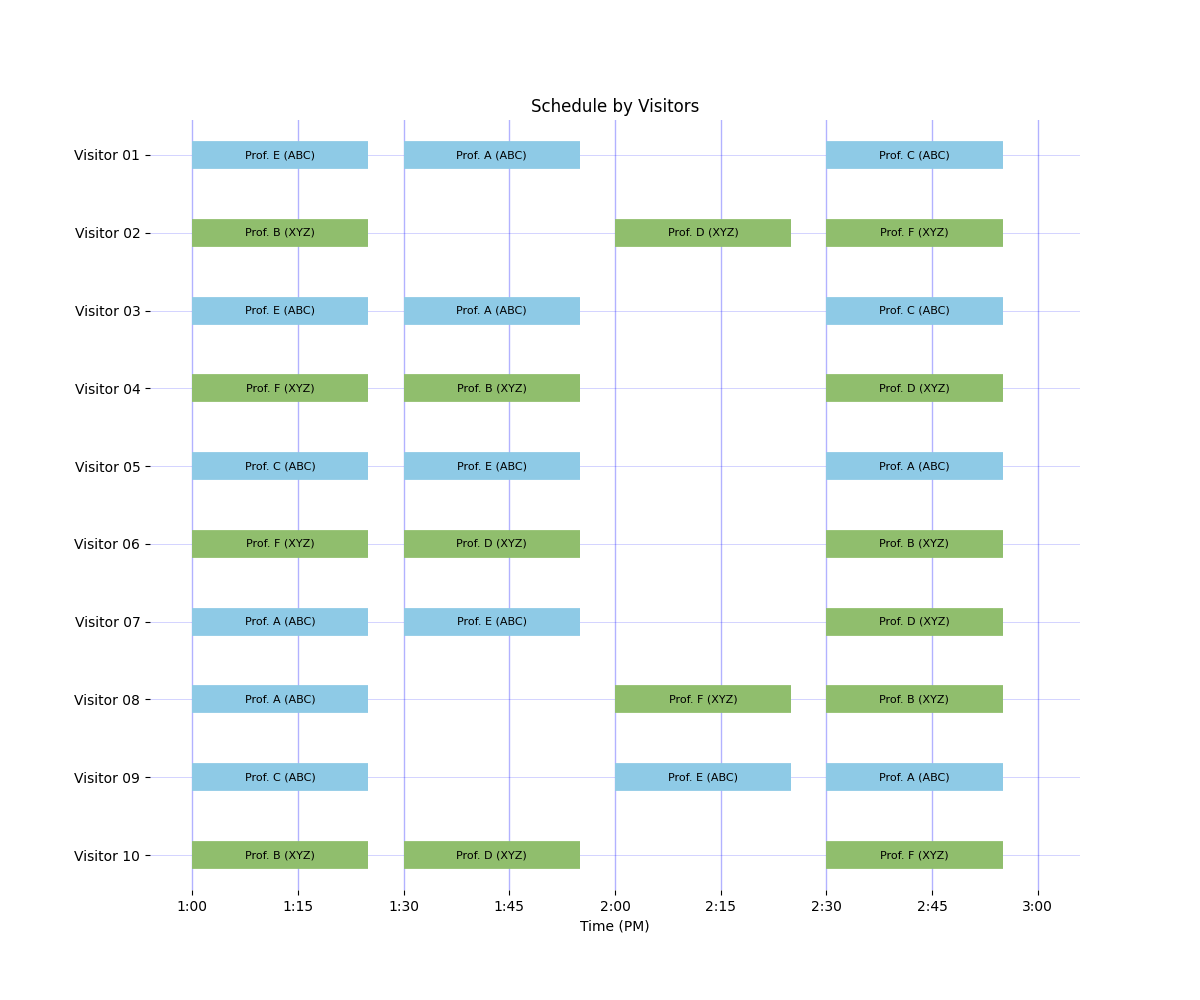

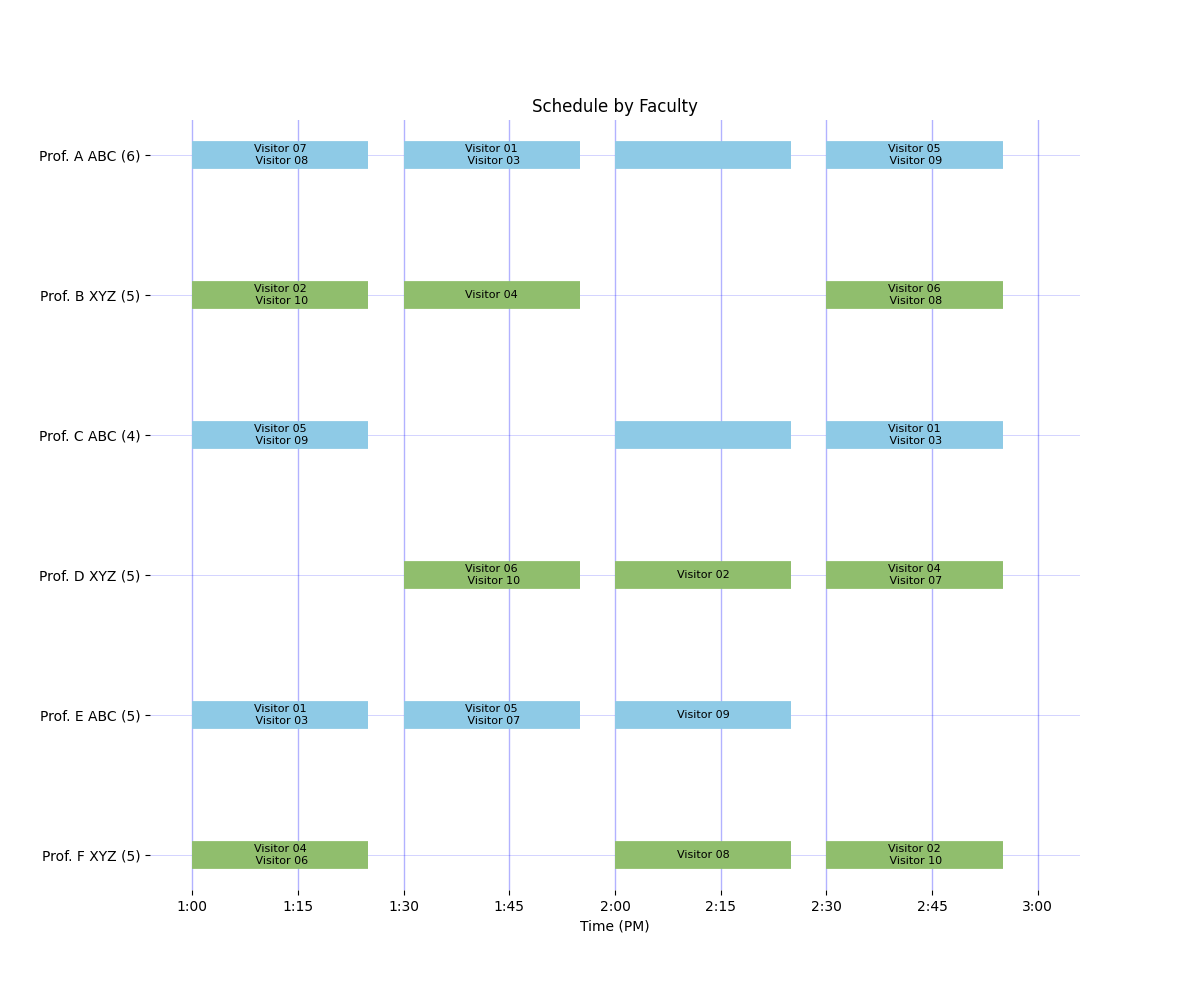

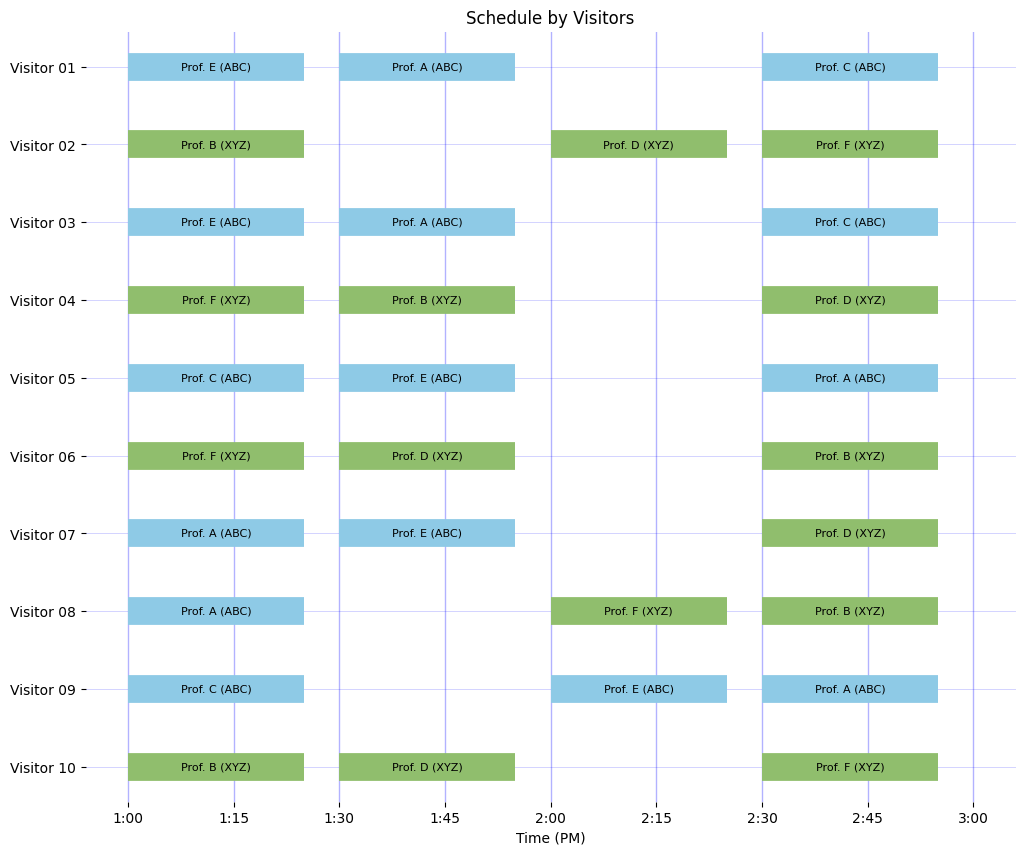

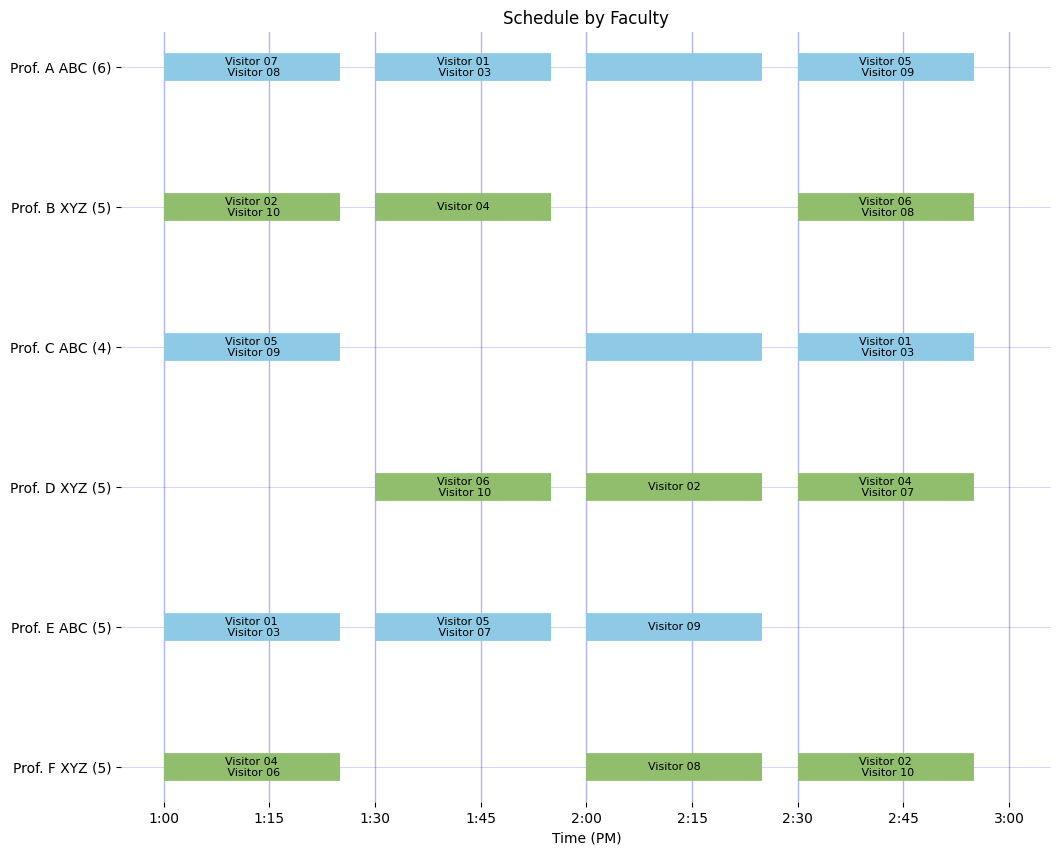

In [7]:
if s.has_feasible_solution():
    s.show_visitor_schedule(save_files=True)
    s.show_faculty_schedule(save_files=True)

    display(Image(filename='visitor_schedule_notebook_demo.png'))
    display(Image(filename='faculty_schedule_notebook_demo.png'))

## 6) Export DOCX

This generates a Word document containing individualized visitor schedules.

In Colab, the cell also attempts a one-click download.

In [8]:
if s.has_feasible_solution():
    docx_path = export_visitor_docx(s, 'visitor_schedule_notebook_demo.docx')
    print(f'DOCX written to: {docx_path}')

    import sys
    if "google.colab" in sys.modules:
        from google.colab import files
        files.download(str(docx_path))


DOCX written to: visitor_schedule_notebook_demo.docx
